# Introduction

#### This notebook will aim to analyze the interaction of Federal Funds Rate set during every Federal Open Market Commitee (FOMC) meeting, with the Standards and Poors 500 (S&P500) index. <br> The S&P500 Index was chosen to help demonstrate the interaction with majority of the stock market. The notebook will observe the effect of changing interests rate on the market, and if different sentiments (hawkish, doveish, hold) affect the stock market differently. <br>

### Section 1: Import and Prepare Data for Analysis <br>

In [52]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from statsmodels.nonparametric.smoothers_lowess import lowess
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
fedrates = pd.read_excel("FedFunds.xlsx")

In [3]:
fedrates.head()

,Date,Rate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.06
3,1954-10-01,0.85
4,1954-11-01,0.83


In [4]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 2 columns):
Date    788 non-null datetime64[ns]
Rate    788 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.4 KB


In [5]:
feddates = pd.read_excel("FOMCDates.xlsx")

In [6]:
feddates.head()

,begdate,scheduled,document,url
0,1954-09-22,1,Record of Policy Actions (115 KB PDF),/monetarypolicy/files/fomcropa19540922.pdf
1,1954-12-07,1,Record of Policy Actions (205 KB PDF),/monetarypolicy/files/fomcropa19541207.pdf
2,1955-01-11,1,Record of Policy Actions (220 KB PDF),/monetarypolicy/files/fomcropa19550111.pdf
3,1955-03-02,1,Record of Policy Actions (343 KB PDF),/monetarypolicy/files/fomcropa19550302.pdf
4,1955-05-10,1,Record of Policy Actions (238 KB PDF),/monetarypolicy/files/fomcropa19550510.pdf


In [7]:
feddates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 4 columns):
begdate      858 non-null datetime64[ns]
scheduled    858 non-null int64
document     810 non-null object
url          766 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 26.9+ KB


In [8]:
feddates = feddates.drop(['document','url'],axis=1)

#### Since both date fields are already datetime format, we can split it by month and year and merge the two datasets and then drop the date column from fedrates since it is monthly data <br>

In [9]:
fedrates['month'] = fedrates['Date'].dt.month
feddates['month'] = feddates['begdate'].dt.month

fedrates['year'] = fedrates['Date'].dt.year
feddates['year'] = feddates['begdate'].dt.year

In [10]:
feddates.head()

,begdate,scheduled,month,year
0,1954-09-22,1,9,1954
1,1954-12-07,1,12,1954
2,1955-01-11,1,1,1955
3,1955-03-02,1,3,1955
4,1955-05-10,1,5,1955


In [11]:
fedrates.head()

,Date,Rate,month,year
0,1954-07-01,0.80,7,1954
1,1954-08-01,1.22,8,1954
2,1954-09-01,1.06,9,1954
3,1954-10-01,0.85,10,1954
4,1954-11-01,0.83,11,1954


In [12]:
fed_funds_data = feddates.merge(fedrates, on=['month','year'])

In [13]:
fed_funds_data.head(10)

,begdate,scheduled,month,year,Date,Rate
0,1954-09-22,1,9,1954,1954-09-01,1.06
1,1954-12-07,1,12,1954,1954-12-01,1.28
2,1955-01-11,1,1,1955,1955-01-01,1.39
3,1955-03-02,1,3,1955,1955-03-01,1.35
4,1955-05-10,1,5,1955,1955-05-01,1.43
5,1955-06-22,1,6,1955,1955-06-01,1.64
6,1955-07-12,1,7,1955,1955-07-01,1.68
7,1955-08-02,1,8,1955,1955-08-01,1.96
8,1955-08-23,1,8,1955,1955-08-01,1.96
9,1955-09-14,1,9,1955,1955-09-01,2.18


In [14]:
fed_funds_data.drop(['month','year','Date'],axis=1,inplace=True)

In [15]:
fed_funds_data.columns = ['MeetingDate', 'WasScheduled?', 'DecidedRate']

In [16]:
fed_funds_data['PreviousRate'] = fed_funds_data['DecidedRate'].shift(1,axis=0)

In [17]:
fed_funds_data['NextRate'] = fed_funds_data['DecidedRate'].shift(-1, axis=0)

In [18]:
fed_funds_data.head()

,MeetingDate,WasScheduled?,DecidedRate,PreviousRate,NextRate
0,1954-09-22,1,1.06,NaN,1.28
1,1954-12-07,1,1.28,1.06,1.39
2,1955-01-11,1,1.39,1.28,1.35
3,1955-03-02,1,1.35,1.39,1.43
4,1955-05-10,1,1.43,1.35,1.64


In [19]:
SP500 = pd.read_excel("SP500Data.xlsx")

In [20]:
SP500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1954-01-04,24.950001,24.950001,24.950001,24.950001,24.950001,1310000
1,1954-01-05,25.100000,25.100000,25.100000,25.100000,25.100000,1520000
2,1954-01-06,25.139999,25.139999,25.139999,25.139999,25.139999,1460000
3,1954-01-07,25.059999,25.059999,25.059999,25.059999,25.059999,1540000
4,1954-01-08,24.930000,24.930000,24.930000,24.930000,24.930000,1260000


In [21]:
sns.set(rc={'figure.figsize':(44,36)})

/Users/vkumar/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


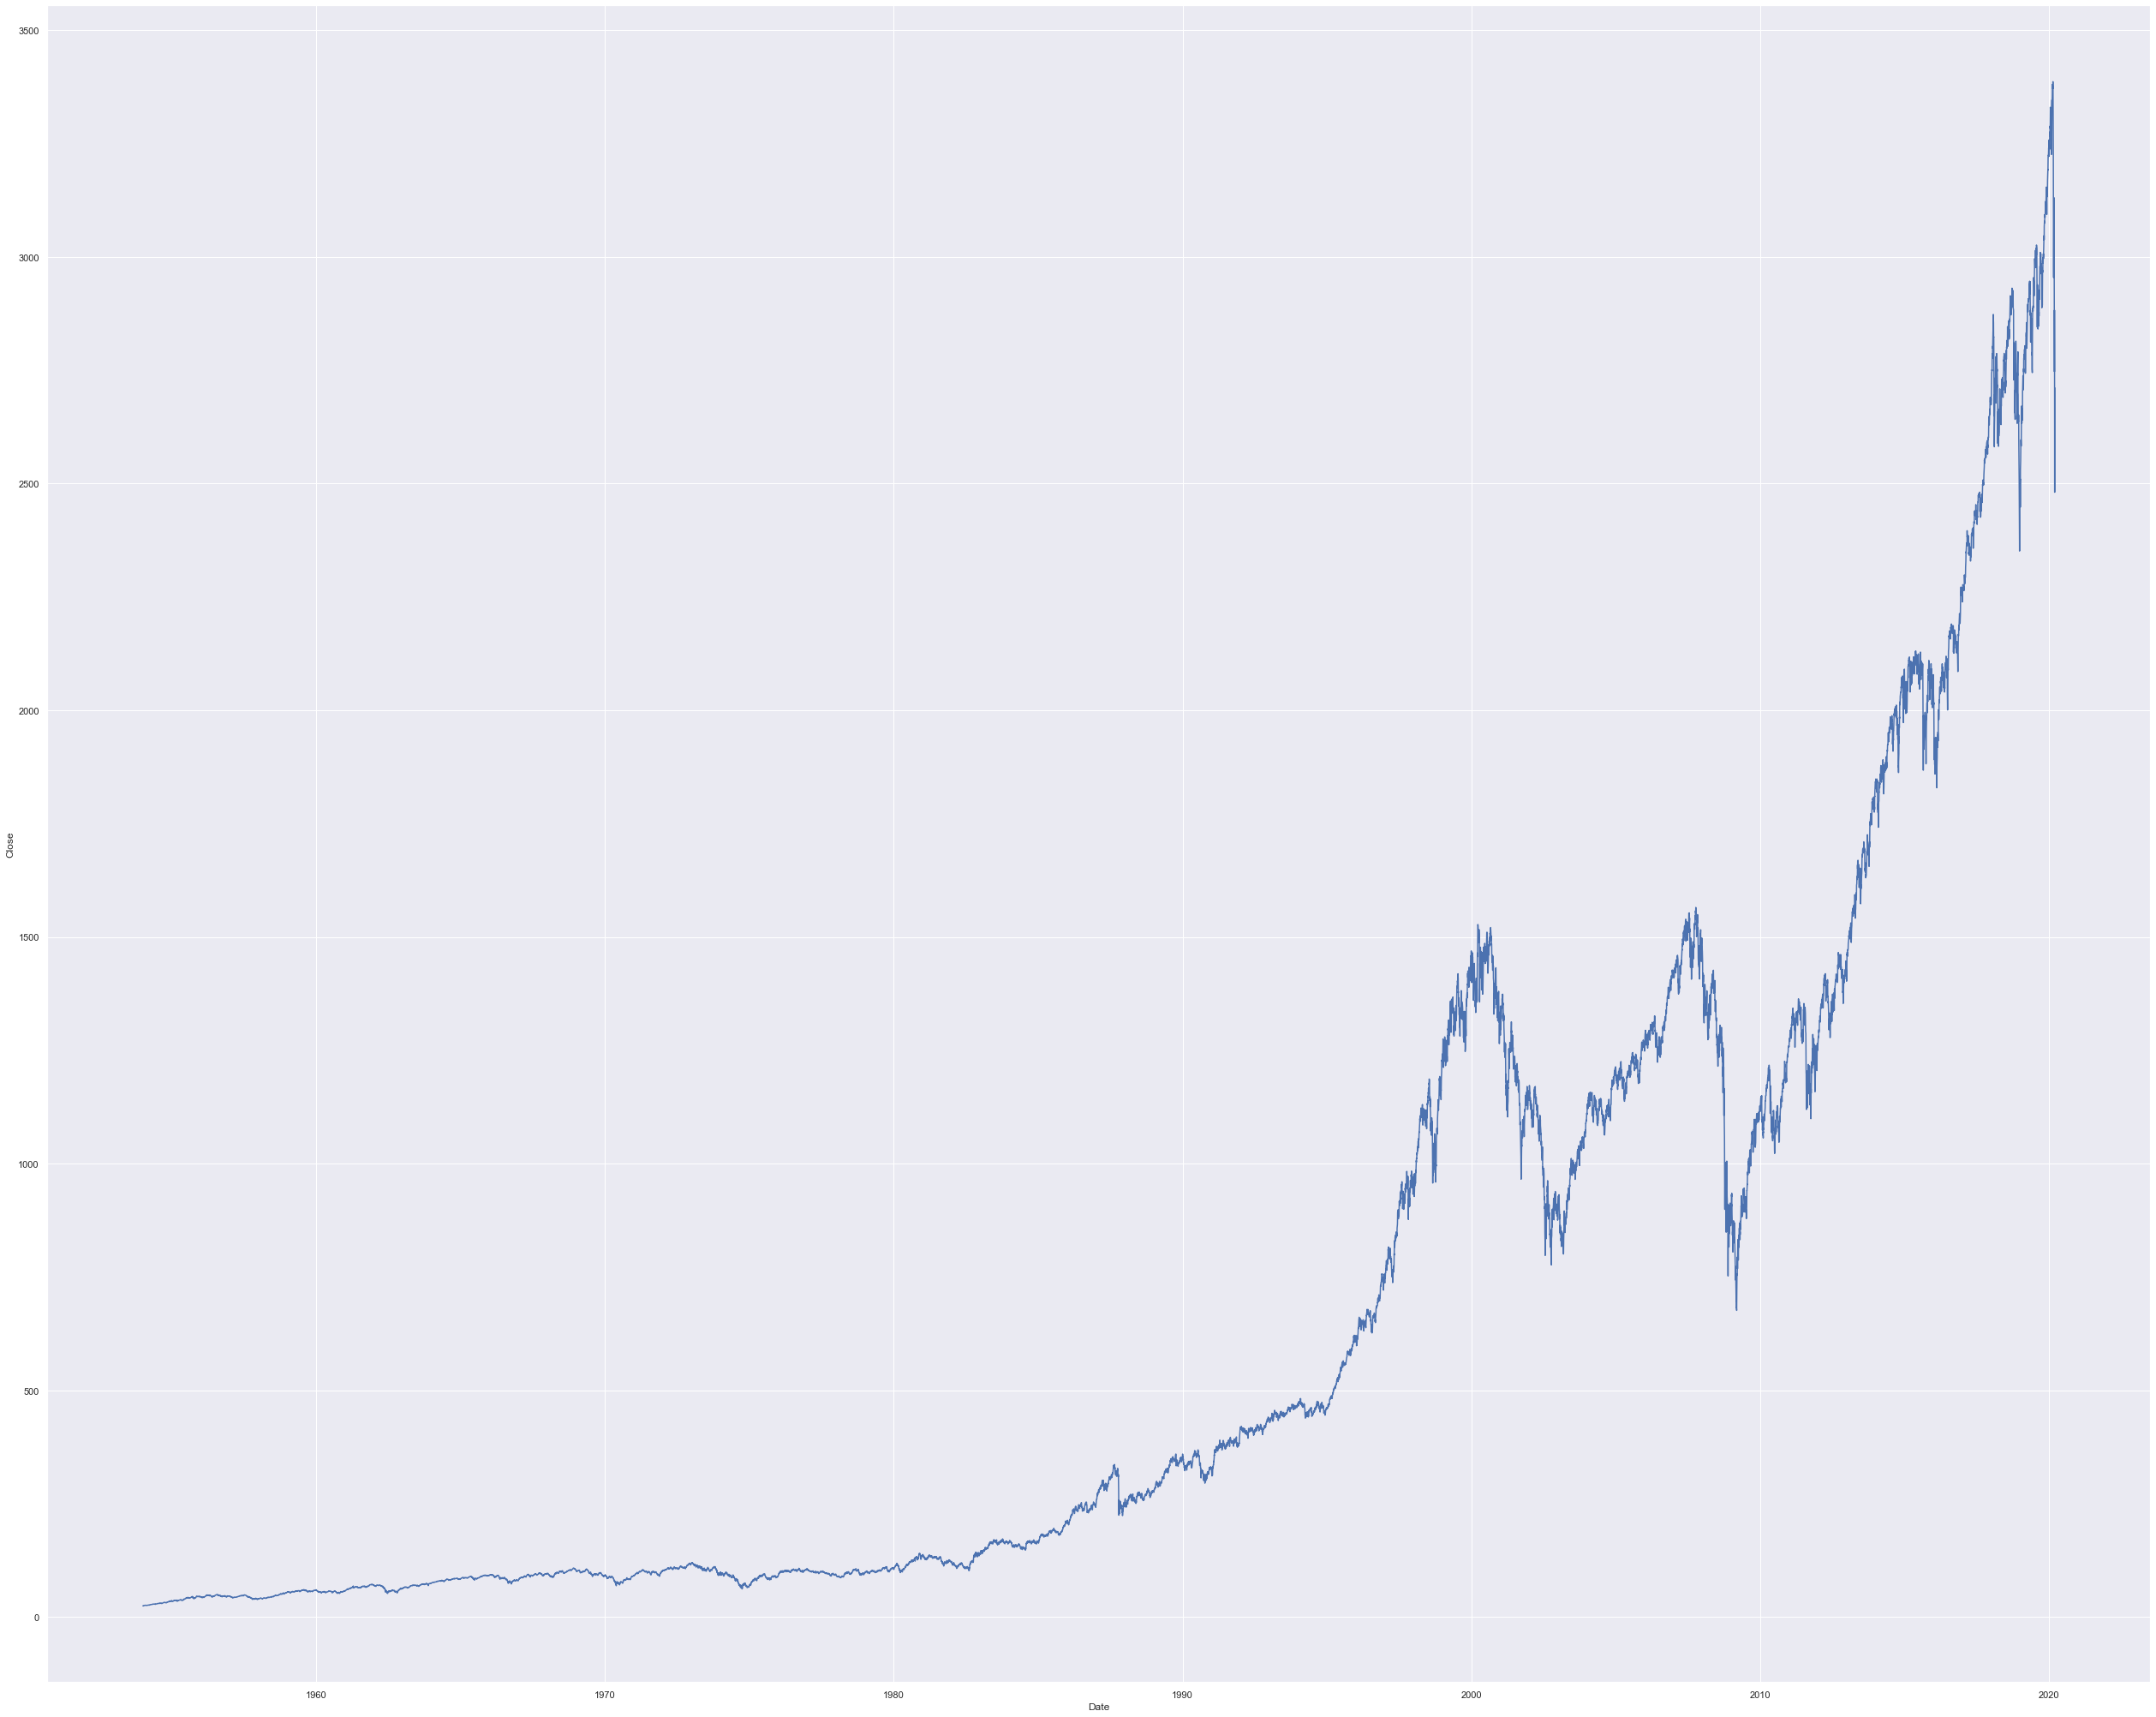

In [22]:
ax1= sns.lineplot(x='Date', y='Close', data=SP500)

### Section 2: Process Dataset<br>

In [23]:
def find_sentiment(data):
    if (data['DecidedRate'] >  data['PreviousRate']) & (data['DecidedRate']- data['PreviousRate'] > 0.15):
        return 'Hawkish'
    elif (data['DecidedRate'] < data['PreviousRate']) & (data['PreviousRate'] - data['DecidedRate'] > 0.15):
        return 'Doveish'
    elif (data['DecidedRate'] - data['NextRate'] > 0.15):
        return 'Hold-Doveish'
    elif (data['NextRate'] - data['DecidedRate'] >  0.15):
        return 'Hold-Hawkish'
    else:
        return 'Hold'
    

In [24]:
fed_funds_data['Sentiment'] = fed_funds_data.apply(find_sentiment, axis=1)

In [25]:
fed_funds_data['Sentiment'].value_counts()

Hold            383
Hawkish         162
Doveish         147
Hold-Hawkish     86
Hold-Doveish     78
Name: Sentiment, dtype: int64

In [26]:
fed_funds_data.head()

,MeetingDate,WasScheduled?,DecidedRate,PreviousRate,NextRate,Sentiment
0,1954-09-22,1,1.06,NaN,1.28,Hold-Hawkish
1,1954-12-07,1,1.28,1.06,1.39,Hawkish
2,1955-01-11,1,1.39,1.28,1.35,Hold
3,1955-03-02,1,1.35,1.39,1.43,Hold
4,1955-05-10,1,1.43,1.35,1.64,Hold-Hawkish


Hawkish    343 <br>
Doveish    275 <br>
Hold       238 <br>

In [27]:
SP500['MaxShift'] = abs(SP500['Low'] - SP500['High'])/SP500['Open']*100
SP500['DailyVolatility'] = (SP500['Close'] - SP500['Open'])/SP500['Open']*100

In [28]:
SP500['MaxShift'].describe()

count    16664.000000
mean         1.231540
std          0.917670
min          0.000000
25%          0.630034
50%          1.176178
75%          1.683046
max         20.470466
Name: MaxShift, dtype: float64

In [29]:
SP500['DailyVolatility'].describe()

count    16664.000000
mean         0.025019
std          0.914612
min        -20.466931
25%         -0.327057
50%          0.000000
75%          0.416123
max         10.789006
Name: DailyVolatility, dtype: float64

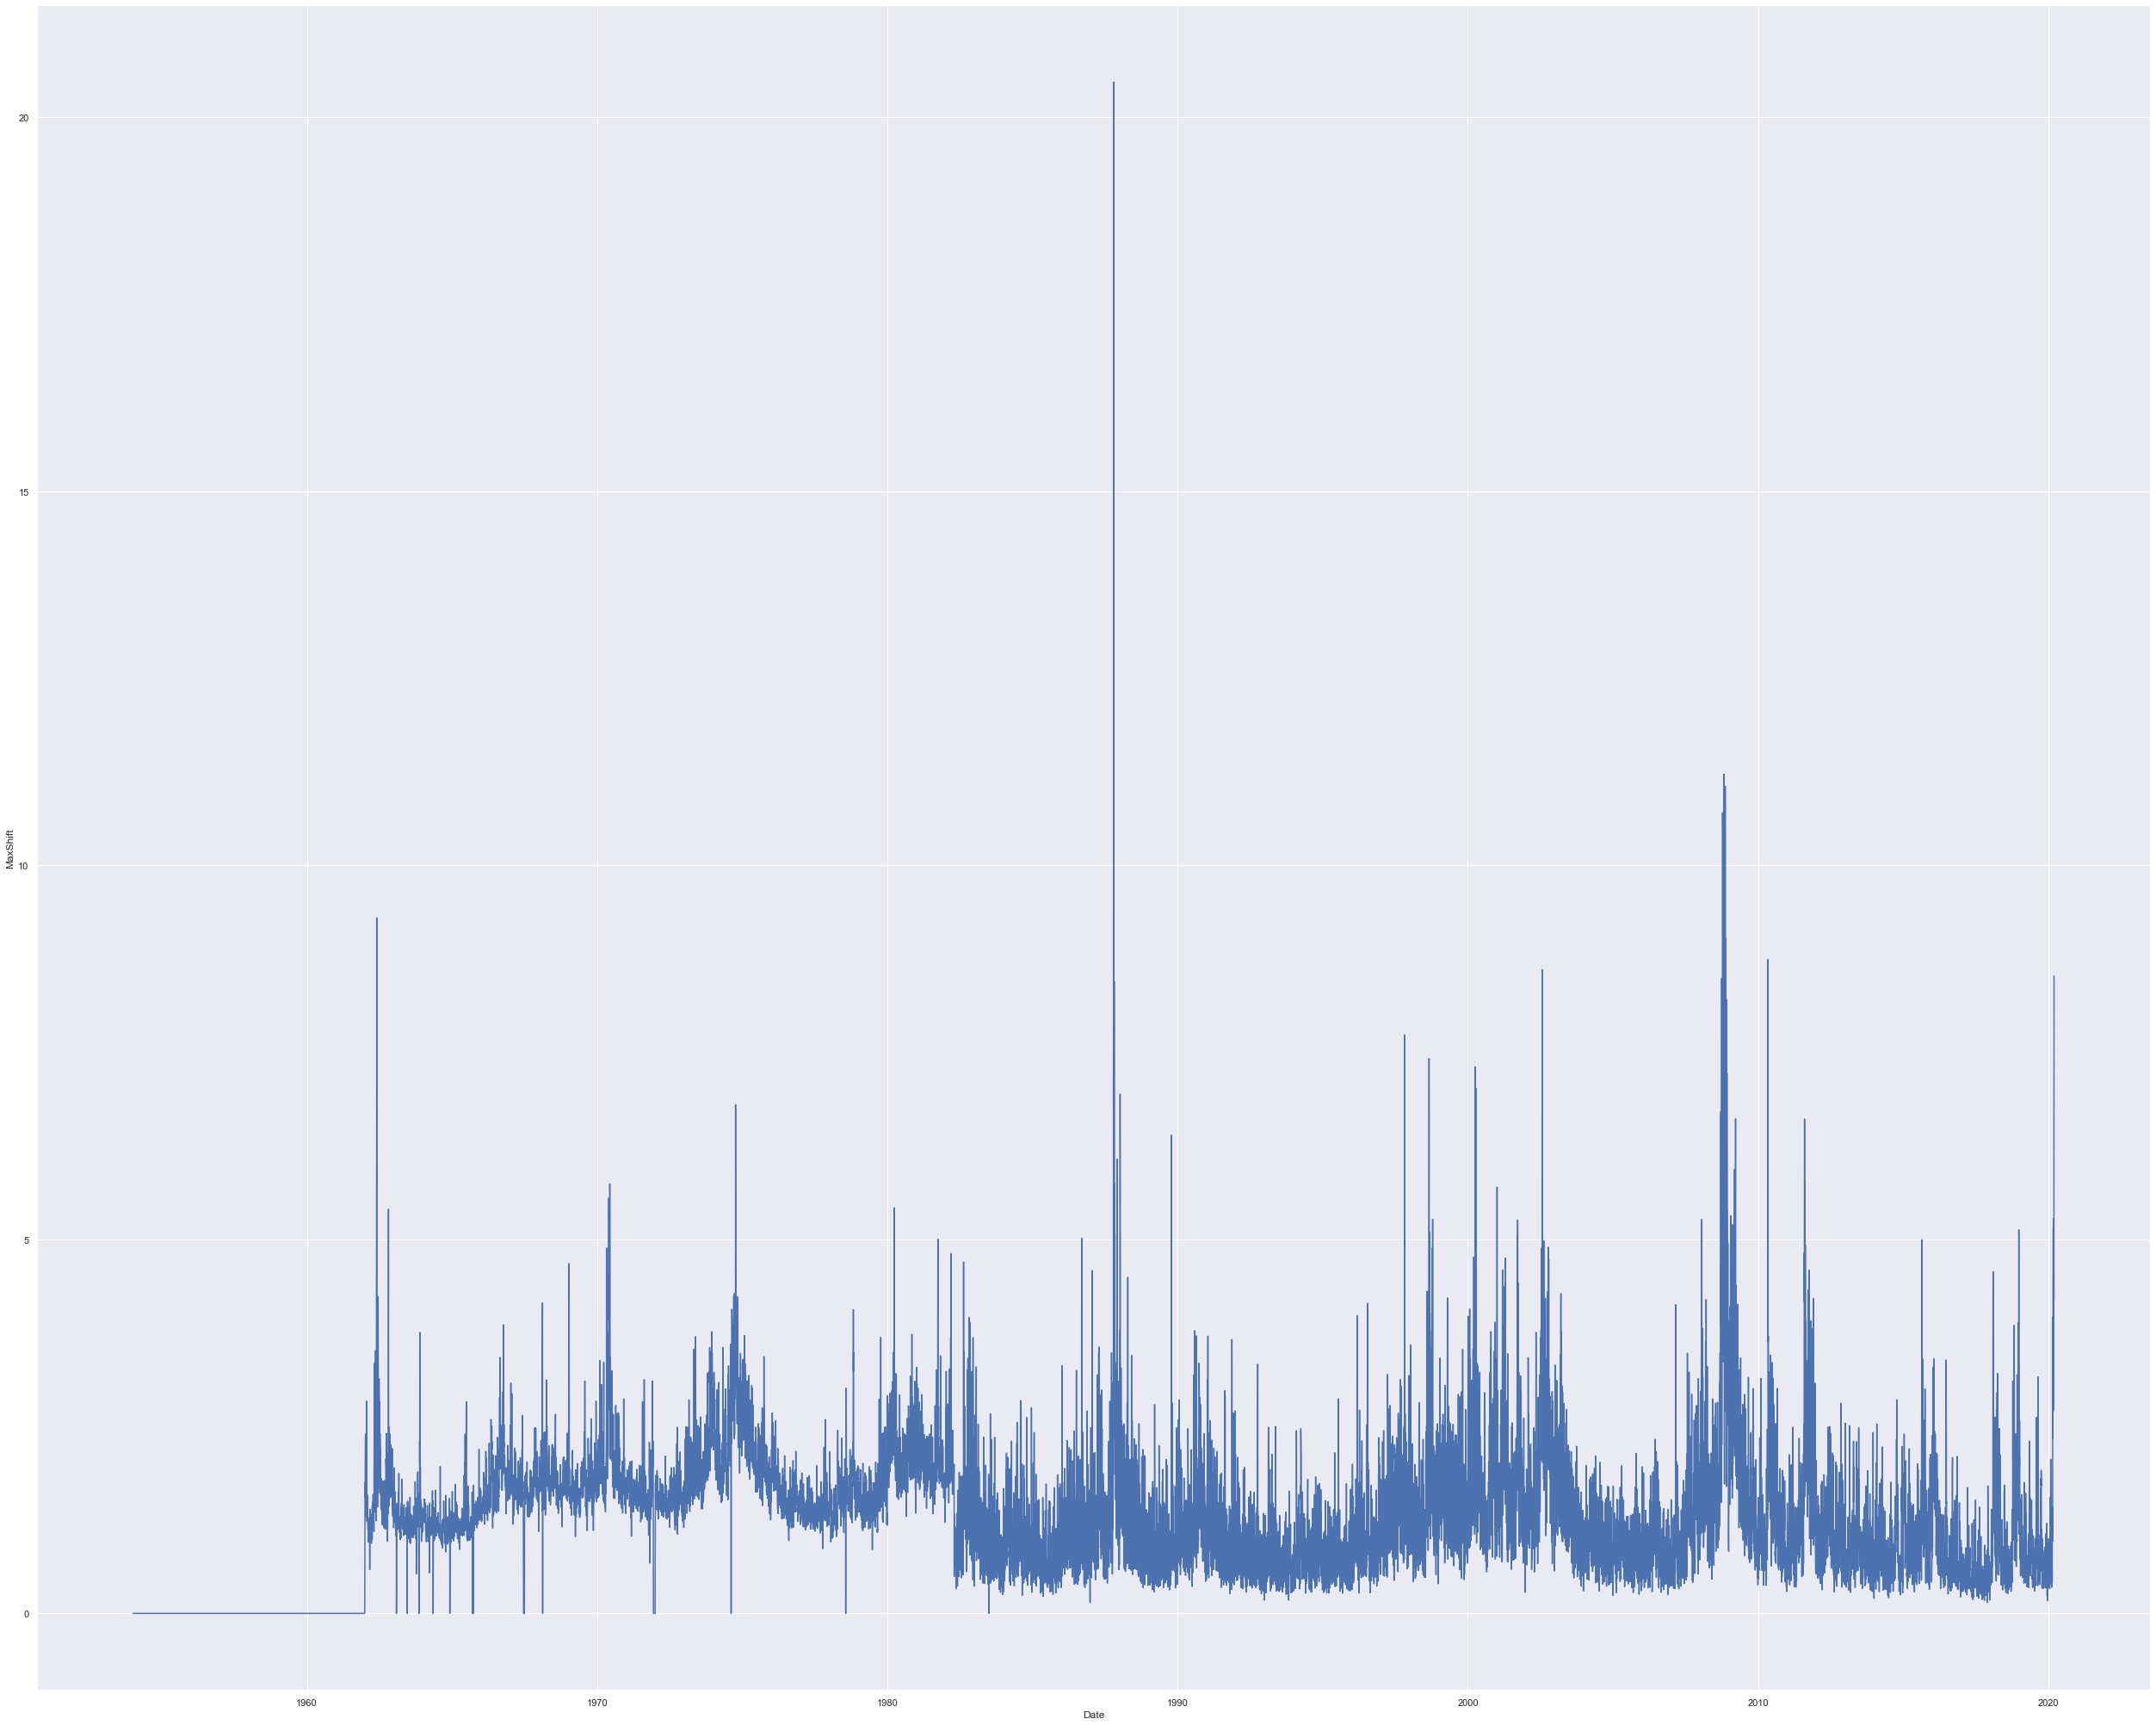

In [30]:
sns.lineplot(x='Date', y='MaxShift', data=SP500)

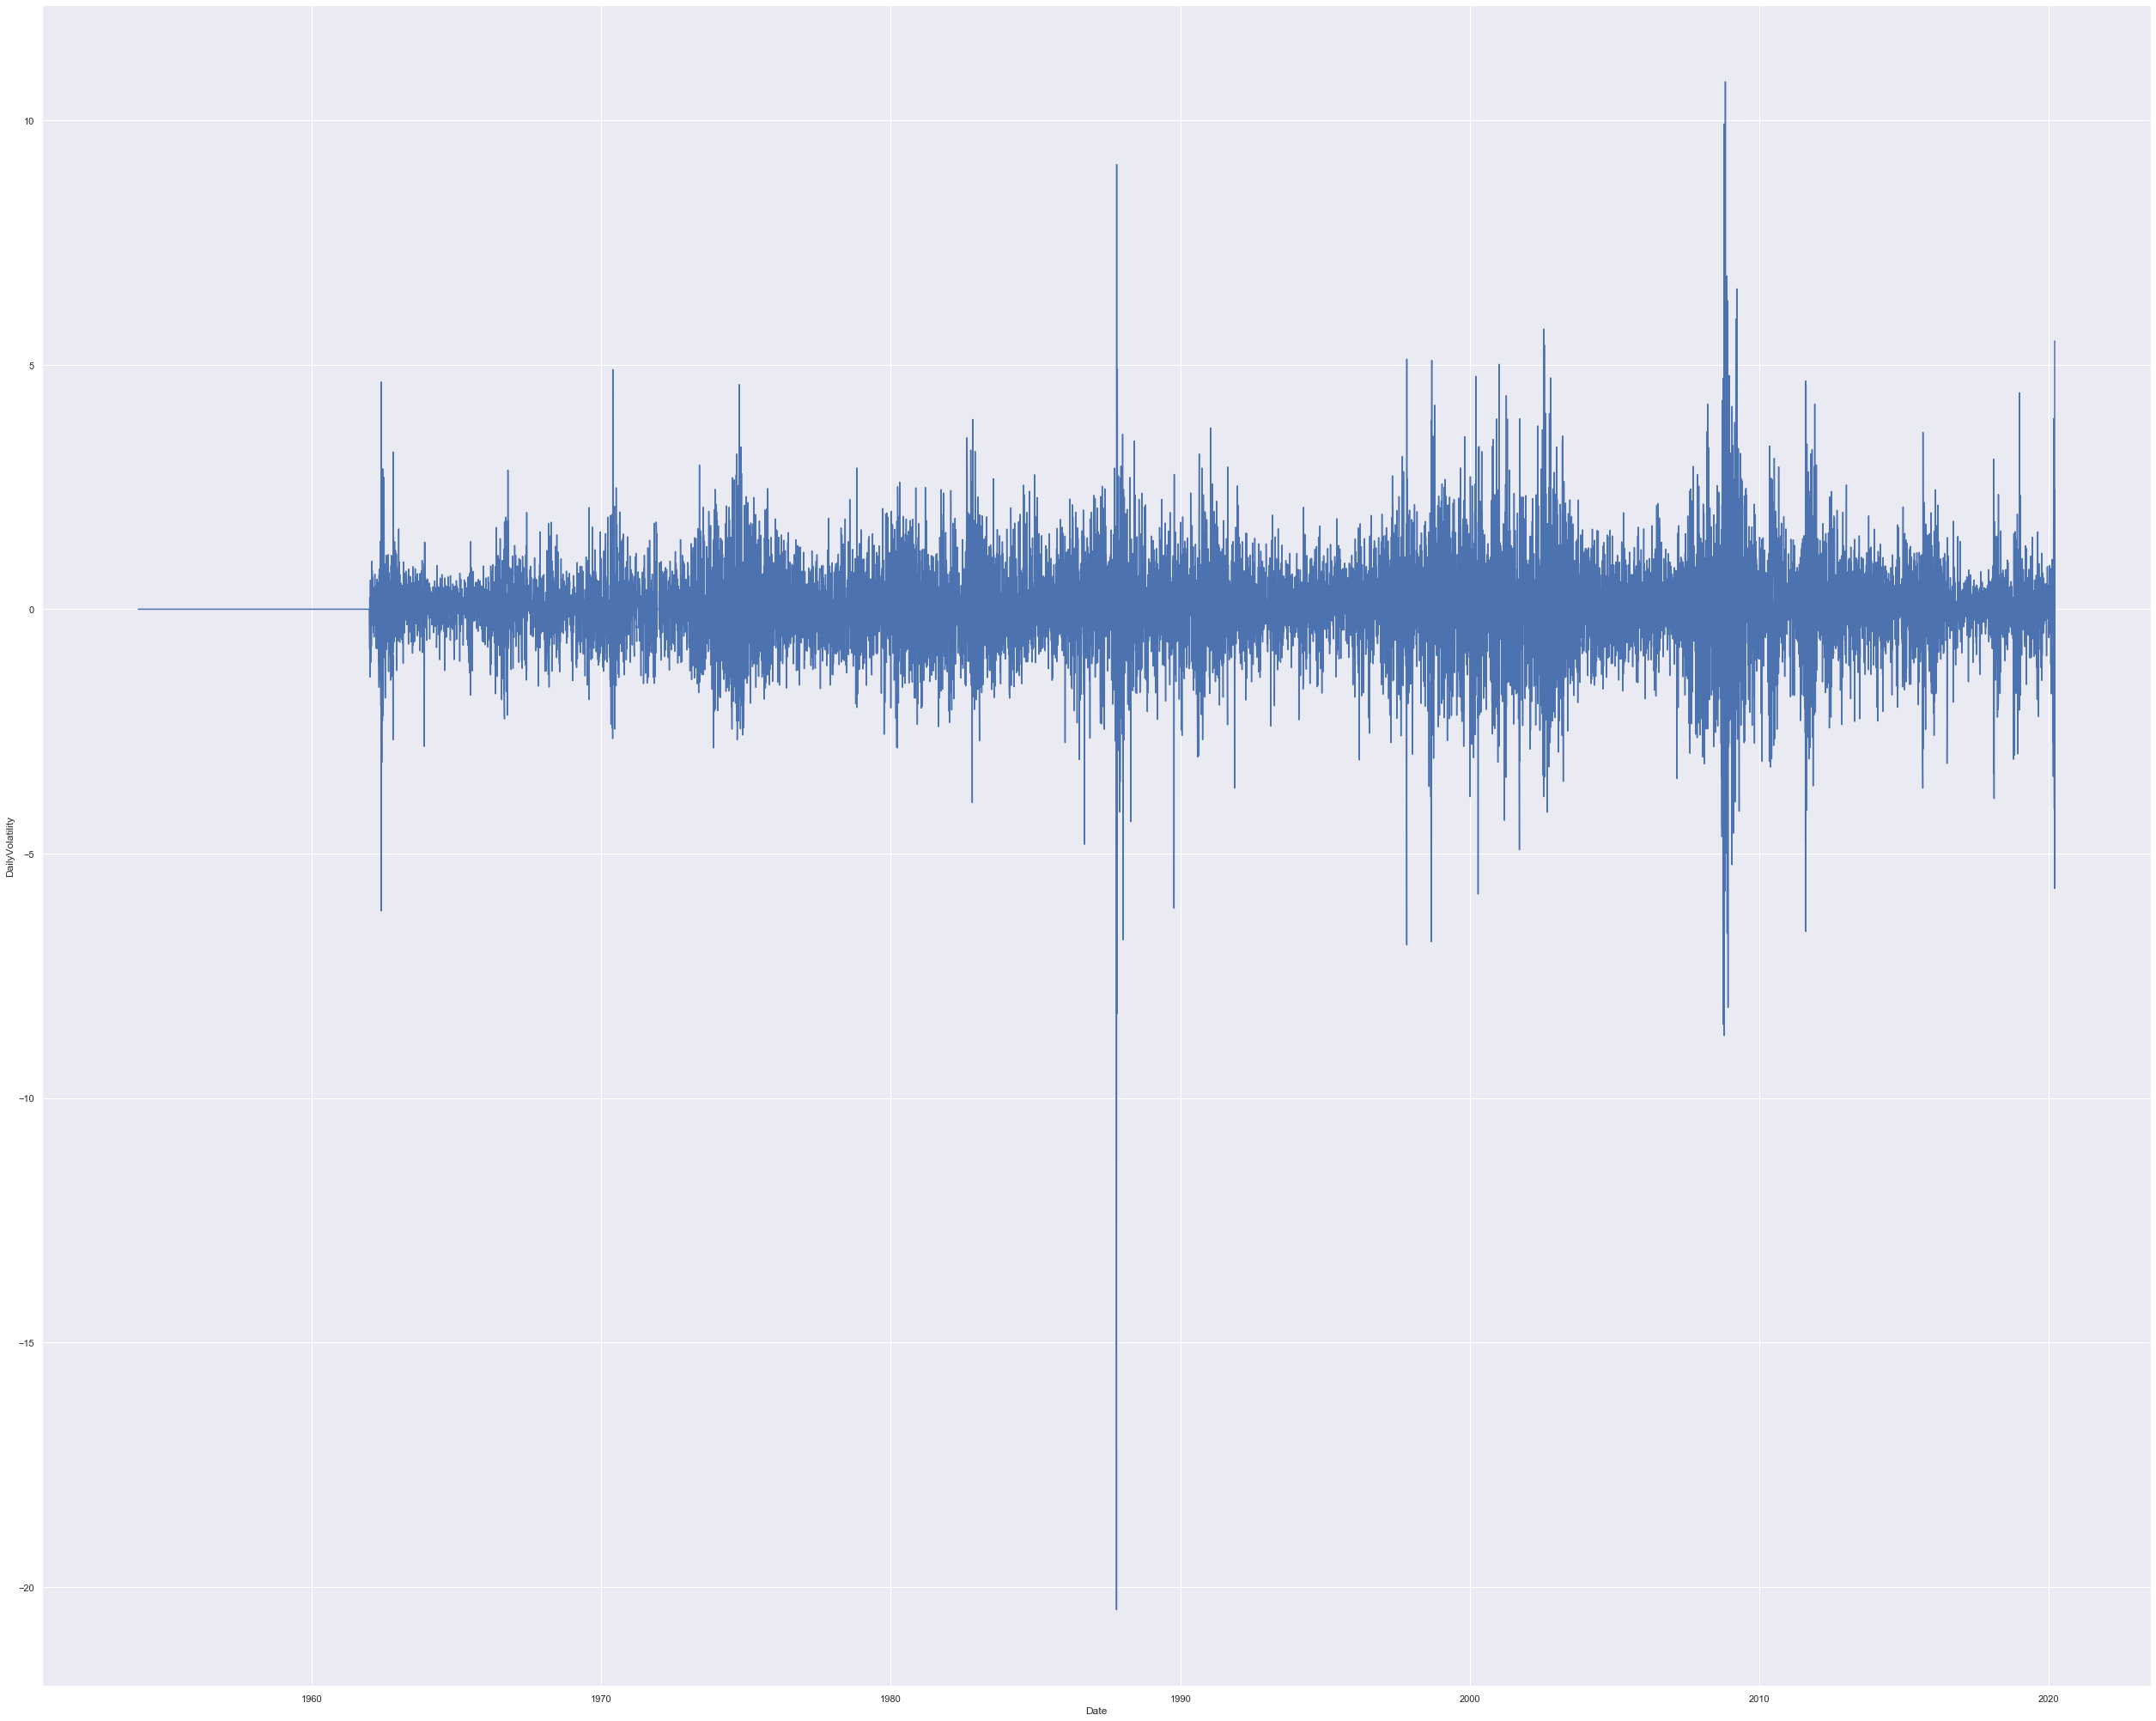

In [31]:
sns.lineplot(x='Date', y='DailyVolatility', data=SP500)

In [32]:
vertical_lines_hold = fed_funds_data[fed_funds_data['Sentiment']=='Hold']['MeetingDate']
vertical_lines_dove = fed_funds_data[fed_funds_data['Sentiment']=='Doveish']['MeetingDate']
vertical_lines_hawk = fed_funds_data[fed_funds_data['Sentiment']=='Hawkish']['MeetingDate']
vertical_lines_hold_hawk = fed_funds_data[fed_funds_data['Sentiment']=='Hold-Hawkish']['MeetingDate']
vertical_lines_hold_dove = fed_funds_data[fed_funds_data['Sentiment']=='Hold-Doveish']['MeetingDate']

In [33]:

from matplotlib.backends.backend_pdf import PdfPages

In [34]:
with PdfPages('SPY_FedFundsRate.pdf') as pdf:
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_hold:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Hold', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_dove:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Doveish', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
              
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_hawk:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Hawkish', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
              
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_hold_hawk:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Hold-Hawkish', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
              
    plt.plot(SP500['Date'],SP500['Close'])
    for date in vertical_lines_hold_dove:
        plt.axvline(x=date, color='r', linestyle='-')
    plt.title('SPY Fed Decision: Hold-Doveish', fontsize=36)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

In [35]:
SP500['PrevDayVolatility'] = SP500['DailyVolatility'].shift(1,axis=0)
SP500['PrevDayMaxShift'] = SP500['MaxShift'].shift(1,axis=0)
SP500['NextDayVolatility'] = SP500['DailyVolatility'].shift(-1,axis=0)
SP500['NextDayMaxShift'] = SP500['MaxShift'].shift(-1,axis=0)
SP500['AvgVolatility'] = (SP500['PrevDayVolatility'] + SP500['DailyVolatility'] + SP500['NextDayVolatility'])/3
SP500['AvgAbsVolatility'] = abs((SP500['PrevDayVolatility'] + SP500['DailyVolatility'] + SP500['NextDayVolatility']))/3
SP500['AvgMaxShift'] = (SP500['PrevDayMaxShift'] + SP500['MaxShift'] + SP500['NextDayMaxShift'])/3

In [36]:
SPY_dove_trend = SP500.merge(vertical_lines_dove, left_on='Date', right_on='MeetingDate')
SPY_hawk_trend = SP500.merge(vertical_lines_hawk, left_on='Date', right_on='MeetingDate')
SPY_hold_trend = SP500.merge(vertical_lines_hold, left_on='Date', right_on='MeetingDate')
SPY_hold_dove_trend = SP500.merge(vertical_lines_hold_dove, left_on='Date', right_on='MeetingDate')
SPY_hold_hawk_trend = SP500.merge(vertical_lines_hold_hawk, left_on='Date', right_on='MeetingDate')

In [37]:
SPY_hawk_trend.shape

(162, 17)

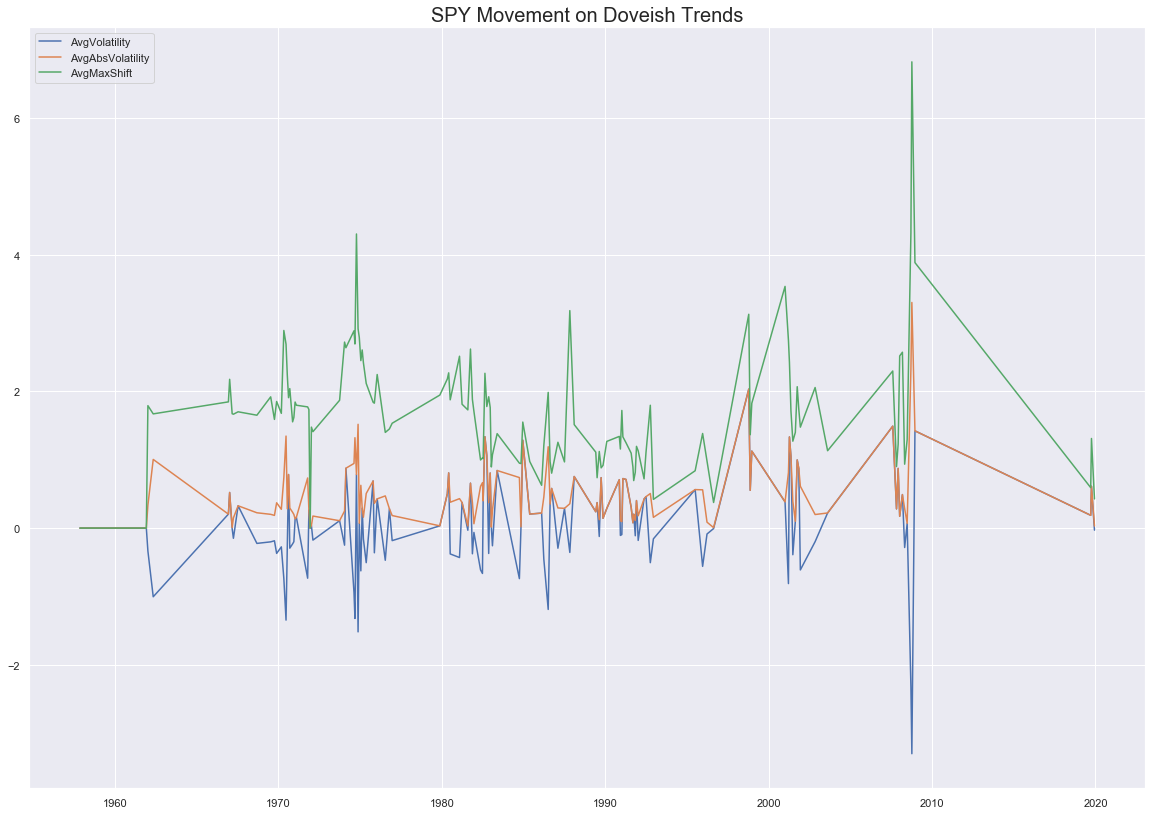

In [38]:
sns.set(rc={'figure.figsize':(20,14)})
X = plt.plot(SPY_dove_trend['Date'], SPY_dove_trend['AvgVolatility'], label="AvgVolatility")
Y = plt.plot(SPY_dove_trend['Date'], SPY_dove_trend['AvgAbsVolatility'], label= 'AvgAbsVolatility')
Z = plt.plot(SPY_dove_trend['Date'], SPY_dove_trend['AvgMaxShift'], label = 'AvgMaxShift')
plt.legend(loc = "upper left")
plt.title("SPY Movement on Doveish Trends", fontsize = '20')
plt.show()

In [39]:
with PdfPages('SPY_SentimentMovement.pdf') as pdf:
    X = plt.plot(SPY_dove_trend['Date'], SPY_dove_trend['AvgVolatility'], label="AvgVolatility")
    Y = plt.plot(SPY_dove_trend['Date'], SPY_dove_trend['AvgAbsVolatility'], label= 'AvgAbsVolatility')
    Z = plt.plot(SPY_dove_trend['Date'], SPY_dove_trend['AvgMaxShift'], label = 'AvgMaxShift')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Doveish Trends", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    
    X = plt.plot(SPY_hawk_trend['Date'], SPY_hawk_trend['AvgVolatility'], label="AvgVolatility")
    Y = plt.plot(SPY_hawk_trend['Date'], SPY_hawk_trend['AvgAbsVolatility'], label= 'AvgAbsVolatility')
    Z = plt.plot(SPY_hawk_trend['Date'], SPY_hawk_trend['AvgMaxShift'], label = 'AvgMaxShift')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Hawkish Trends", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
        
    X = plt.plot(SPY_hold_trend['Date'], SPY_hold_trend['AvgVolatility'], label="AvgVolatility")
    Y = plt.plot(SPY_hold_trend['Date'], SPY_hold_trend['AvgAbsVolatility'], label= 'AvgAbsVolatility')
    Z = plt.plot(SPY_hold_trend['Date'], SPY_hold_trend['AvgMaxShift'], label = 'AvgMaxShift')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Holding Trends", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    
    X = plt.plot(SPY_hold_dove_trend['Date'], SPY_hold_dove_trend['AvgVolatility'], label="AvgVolatility")
    Y = plt.plot(SPY_hold_dove_trend['Date'], SPY_hold_dove_trend['AvgAbsVolatility'], label= 'AvgAbsVolatility')
    Z = plt.plot(SPY_hold_dove_trend['Date'], SPY_hold_dove_trend['AvgMaxShift'], label = 'AvgMaxShift')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Hold-Doveish Trends", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
        
    X = plt.plot(SPY_hold_hawk_trend['Date'], SPY_hold_hawk_trend['AvgVolatility'], label="AvgVolatility")
    Y = plt.plot(SPY_hold_hawk_trend['Date'], SPY_hold_hawk_trend['AvgAbsVolatility'], label= 'AvgAbsVolatility')
    Z = plt.plot(SPY_hold_hawk_trend['Date'], SPY_hold_hawk_trend['AvgMaxShift'], label = 'AvgMaxShift')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Hold-Hawkish Trends", fontsize = '20')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

## Section: Split Datasets into different time periods and see Fed Decision trends across these time periods. Recession dates are incorrect since it took all dates. Learning experience.

In [93]:
#import recession dates from https://fred.stlouisfed.org/series/JHDUSRGDPBR
recessions = pd.read_excel("US_recessions.xlsx")

In [94]:
recessions['Date'] = pd.to_datetime(recessions['Date'])
recessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19358 entries, 0 to 19357
Data columns (total 2 columns):
Date                 19358 non-null datetime64[ns]
IsRecessionLikely    19358 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 302.6 KB


In [97]:
recession_dates = recessions.loc[recessions['IsRecessionLikely']==1]
recession_dates.head()

,Date,IsRecessionLikely
821,1969-04-01,1
822,1969-04-02,1
823,1969-04-03,1
824,1969-04-04,1
825,1969-04-05,1


In [98]:
SP500_recessions = SP500.merge(recession_dates, left_on='Date', right_on='Date')
SP500_recessions.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MaxShift,DailyVolatility,PrevDayVolatility,PrevDayMaxShift,NextDayVolatility,NextDayMaxShift,AvgVolatility,AvgAbsVolatility,AvgMaxShift,IsRecessionLikely
0,1969-04-01,101.510002,102.449997,100.839996,101.419998,101.419998,12360000,1.586052,-0.088665,0.405543,1.602369,-0.631038,1.025440,-0.104720,0.104720,1.404620,1
1,1969-04-02,101.419998,101.650002,100.610001,100.779999,100.779999,10110000,1.025440,-0.631038,-0.088665,1.586052,-0.099225,1.418932,-0.272976,0.272976,1.343475,1
2,1969-04-03,100.779999,101.300003,99.870003,100.680000,100.680000,10300000,1.418932,-0.099225,-0.631038,1.025440,-0.735365,1.540291,-0.488543,0.488543,1.328221,1
3,1969-04-07,100.629997,100.629997,99.080002,99.889999,99.889999,9430000,1.540291,-0.735365,-0.099225,1.418932,0.250275,1.922113,-0.194772,0.194772,1.627112,1
4,1969-04-08,99.889999,101.269997,99.349998,100.139999,100.139999,9360000,1.922113,0.250275,-0.735365,1.540291,0.878768,1.557824,0.131226,0.131226,1.673410,1


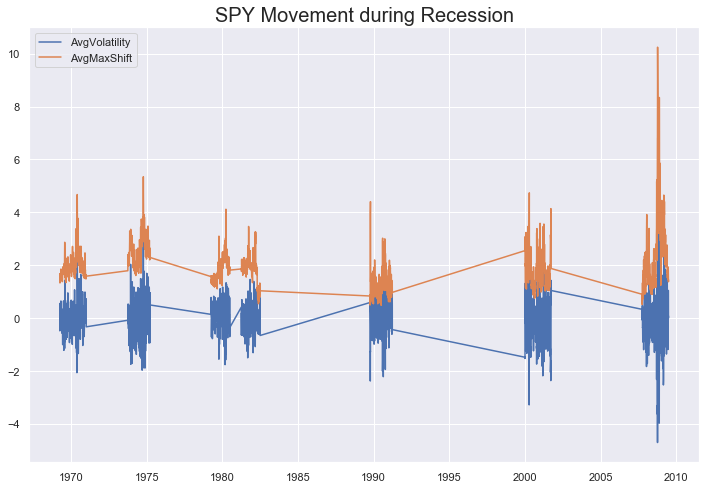

In [99]:
sns.set(rc={'figure.figsize':(12,8)})
X = plt.plot(SP500_recessions['Date'], SP500_recessions['AvgVolatility'], label="AvgVolatility")
Z = plt.plot(SP500_recessions['Date'], SP500_recessions['AvgMaxShift'], label = 'AvgMaxShift')
plt.legend(loc = "upper left")
plt.title("SPY Movement during Recession", fontsize = '20')
plt.show()

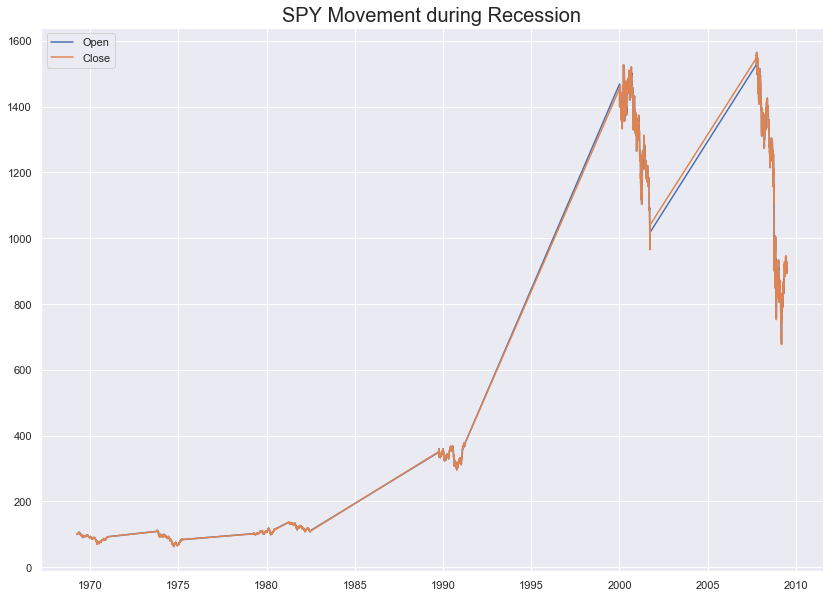

In [101]:
sns.set(rc={'figure.figsize':(14,10)})
X = plt.plot(SP500_recessions['Date'], SP500_recessions['Open'], label="Open")
Z = plt.plot(SP500_recessions['Date'], SP500_recessions['Close'], label = 'Close')
plt.legend(loc = "upper left")
plt.title("SPY Movement during Recession", fontsize = '20')
plt.show()

In [102]:
Recession_SPY_dove_trend = SP500_recessions.merge(vertical_lines_dove, left_on='Date', right_on='MeetingDate')
Recession_SPY_hawk_trend = SP500_recessions.merge(vertical_lines_hawk, left_on='Date', right_on='MeetingDate')
Recession_SPY_hold_trend = SP500_recessions.merge(vertical_lines_hold, left_on='Date', right_on='MeetingDate')
Recession_SPY_hold_dove_trend = SP500_recessions.merge(vertical_lines_hold_dove, left_on='Date', right_on='MeetingDate')
Recession_SPY_hold_hawk_trend = SP500_recessions.merge(vertical_lines_hold_hawk, left_on='Date', right_on='MeetingDate')

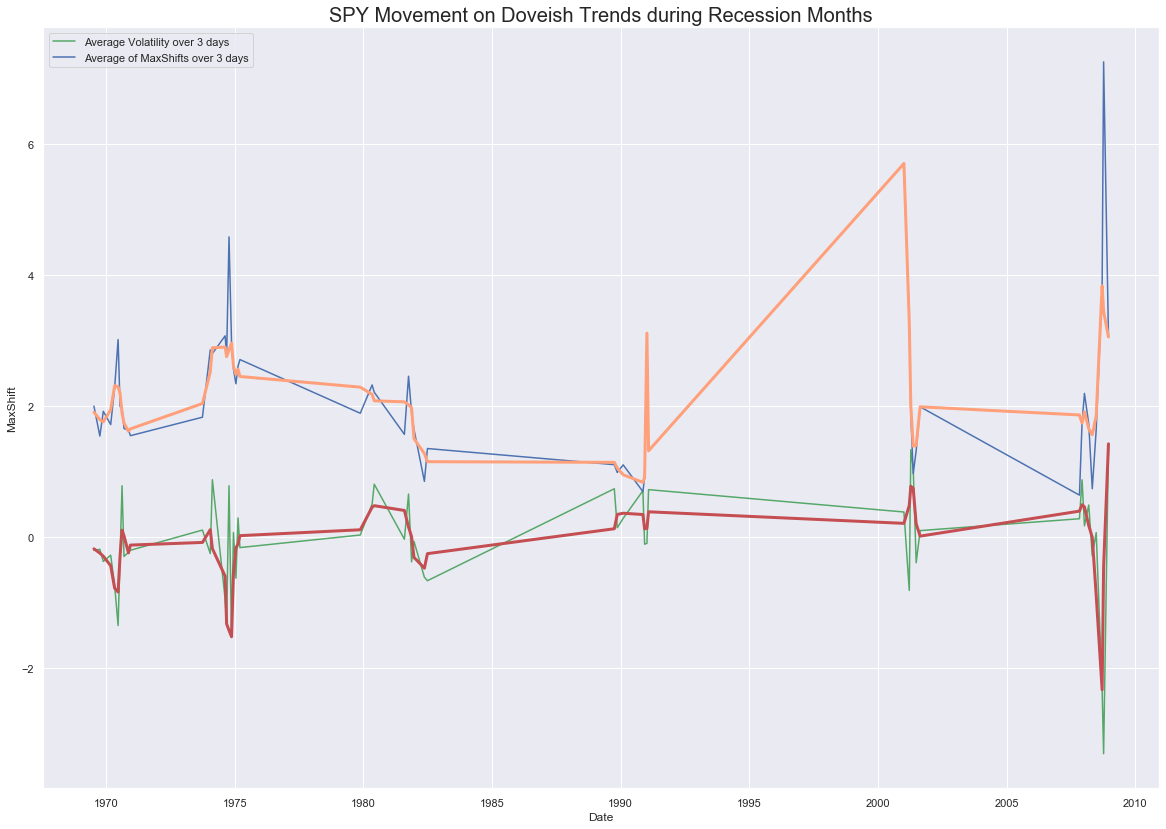

In [103]:
sns.set(rc={'figure.figsize':(20,14)})
X = plt.plot(Recession_SPY_dove_trend['Date'], Recession_SPY_dove_trend['AvgVolatility'], label="Average Volatility over 3 days", color='g')
Y = plt.plot(Recession_SPY_dove_trend['Date'], Recession_SPY_dove_trend['MaxShift'], label="Average of MaxShifts over 3 days", color='b')
plt.legend(loc = "upper left")
plt.title("SPY Movement on Doveish Trends during Recession Months", fontsize = '20')

rSPYplot = Recession_SPY_dove_trend.set_index('Date')
loess_x = pd.DataFrame(lowess(rSPYplot['AvgVolatility'], np.arange(len(rSPYplot['AvgVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgVolatility'])
sns.lineplot(x = rSPYplot.index, y = 'AvgVolatility', linewidth = 3, data = loess_x, color='r')
loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='lightsalmon')

plt.show()

In [104]:
with PdfPages('SPY_Recession_SentimentMovement.pdf') as pdf:
    X = plt.plot(Recession_SPY_dove_trend['Date'], Recession_SPY_dove_trend['AvgVolatility'], label="Average Volatility over 3 days", color='g')
    Y = plt.plot(Recession_SPY_dove_trend['Date'], Recession_SPY_dove_trend['MaxShift'], label="Average of MaxShifts over 3 days", color='b')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Doveish Trends during Recession Months", fontsize = '20')

    rSPYplot = Recession_SPY_dove_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgVolatility'], np.arange(len(rSPYplot['AvgVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='lightsalmon')
    
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------
    
    X = plt.plot(Recession_SPY_hawk_trend['Date'], Recession_SPY_hawk_trend['AvgVolatility'], label="Average Volatility over 3 days", color='g')
    Y = plt.plot(Recession_SPY_hawk_trend['Date'], Recession_SPY_hawk_trend['MaxShift'], label="Average of MaxShifts over 3 days", color='b')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Hawkish Trends during Recession Months", fontsize = '20')
    
    rSPYplot = Recession_SPY_hawk_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgVolatility'], np.arange(len(rSPYplot['AvgVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='lightsalmon')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------
        
    X = plt.plot(Recession_SPY_hold_trend['Date'], Recession_SPY_hold_trend['AvgVolatility'], label="Average Volatility over 3 days", color='g')
    Y = plt.plot(Recession_SPY_hold_trend['Date'], Recession_SPY_hold_trend['MaxShift'], label="Average of MaxShifts over 3 days", color='b')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Holding Trends during Recession Months", fontsize = '20')
    
    rSPYplot = Recession_SPY_hold_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgVolatility'], np.arange(len(rSPYplot['AvgVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='lightsalmon')
    
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------
    
    X = plt.plot(Recession_SPY_hold_dove_trend['Date'], Recession_SPY_hold_dove_trend['AvgVolatility'], label="Average Volatility over 3 days", color='g')
    Y = plt.plot(Recession_SPY_hold_dove_trend['Date'], Recession_SPY_hold_dove_trend['MaxShift'], label="Average of MaxShifts over 3 days", color='b')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Hold-Doveish Trends during Recession Months", fontsize = '20')
    
    rSPYplot = Recession_SPY_hold_dove_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgVolatility'], np.arange(len(rSPYplot['AvgVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='lightsalmon')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------
    
    X = plt.plot(Recession_SPY_hold_hawk_trend['Date'], Recession_SPY_hold_hawk_trend['AvgVolatility'], label="Average Volatility over 3 days", color='g')
    Y = plt.plot(Recession_SPY_hold_hawk_trend['Date'], Recession_SPY_hold_hawk_trend['MaxShift'], label="Average of MaxShifts over 3 days", color='b')
    plt.legend(loc = "upper left")
    plt.title("SPY Movement on Hold-Hawkish Trends during Recession Months", fontsize = '20')
    
    rSPYplot = Recession_SPY_hold_hawk_trend.set_index('Date')
    loess_x = pd.DataFrame(lowess(rSPYplot['AvgVolatility'], np.arange(len(rSPYplot['AvgVolatility'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['AvgVolatility'])
    sns.lineplot(x = rSPYplot.index, y = 'AvgVolatility', linewidth = 3, data = loess_x, color='r')
    loess_y = pd.DataFrame(lowess(rSPYplot['MaxShift'], np.arange(len(rSPYplot['MaxShift'])), frac=0.09)[:, 1], index=rSPYplot.index, columns=['MaxShift'])
    sns.lineplot(x = rSPYplot.index, y = 'MaxShift', linewidth = 3, data = loess_y, color='lightsalmon')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

#### Post Recession: Check movement during unscheduled Fed meetings

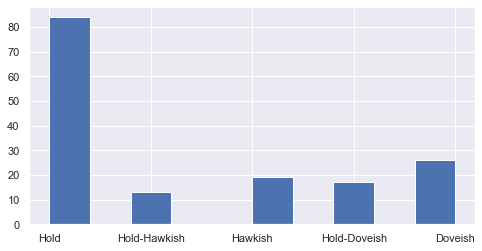

In [87]:
sns.set(rc={'figure.figsize':(8,4)})
unscheduled_fed = fed_funds_data.loc[fed_funds_data['WasScheduled?']==0]
unscheduled_fed.Sentiment.hist()

In [92]:
# vertical_lines_hold = fed_funds_data[fed_funds_data['Sentiment']=='Hold']['MeetingDate']
# vertical_lines_dove = fed_funds_data[fed_funds_data['Sentiment']=='Doveish']['MeetingDate']
# vertical_lines_hawk = fed_funds_data[fed_funds_data['Sentiment']=='Hawkish']['MeetingDate']
# vertical_lines_hold_hawk = fed_funds_data[fed_funds_data['Sentiment']=='Hold-Hawkish']['MeetingDate']
# vertical_lines_hold_dove = fed_funds_data[fed_funds_data['Sentiment']=='Hold-Doveish']['MeetingDate']
recession_dates['Year'] = recession_dates.Date.dt.year
recession_dates.to_csv("CheckDates.csv")